In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('../data/220316_ghost_nrt_filtered.tsv', sep='\t')
design_matrix = pd.read_csv('../data/design_matrix_group_de_early_time_points_subtypes.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values


### Peptide distribution in samples

1039 unique proteins


<Figure size 432x288 with 0 Axes>

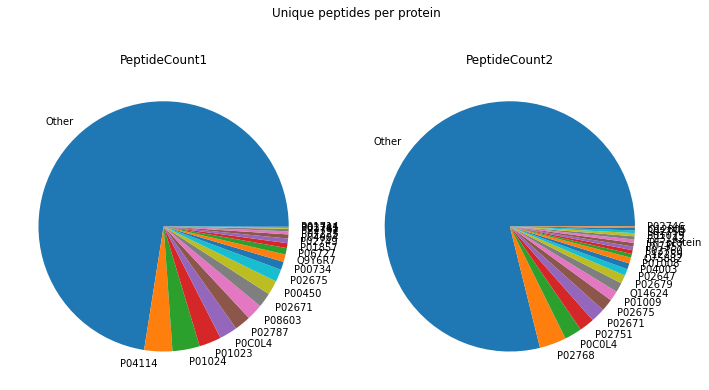

In [66]:
nr_unique_proteins = len(df['Protein'].unique())
print(f'{nr_unique_proteins} unique proteins')

df['PeptideCount1'] = df[GroupOneCols].count(axis=1)
df['PeptideCount2'] = df[GroupTwoCols].count(axis=1)
df['IntensitySum1'] = df[GroupOneCols].sum(axis=1)
df['IntensitySum2'] = df[GroupTwoCols].sum(axis=1)
df['IntensityMean1'] = df[GroupOneCols].mean(axis=1)
df['IntensityMean2'] = df[GroupTwoCols].mean(axis=1)

def savefig(figureFileName):
    plt.tight_layout()
    plt.savefig(f'../plots/{figureFileName}.jpg', dpi=300, bbox_inches='tight')

def plot_peptides_per_protein_piechart(df):
    plt.clf()
    nr_proteins = 25
    def make_other_label(row, top_x_proteins):
        if row['Protein'] in top_x_proteins:
               return row['Protein']
        else:
            return 'Other'
    fig, axs = plt.subplots(1,2, figsize=(10,6))
    for ax, PeptideCount in zip(axs.ravel(), ['PeptideCount1','PeptideCount2']):
        df.sort_values(PeptideCount, ascending=False, inplace=True)
        top_x_proteins = df['Protein'][0:nr_proteins].values
        df['labels'] = df.apply(lambda x: make_other_label(x, top_x_proteins), axis=1)
        df_grouped = df.groupby('labels', as_index=False).sum()
        df_grouped.sort_values(PeptideCount, ascending=False, inplace=True)
        ax.pie(x=df_grouped[PeptideCount].values[0:nr_proteins], labels=df_grouped['labels'].values[0:nr_proteins])
        ax.set_title(PeptideCount)
    plt.suptitle('Unique peptides per protein')
    savefig('Protein_pie')
    
plot_peptides_per_protein_piechart(df)


<Figure size 432x288 with 0 Axes>

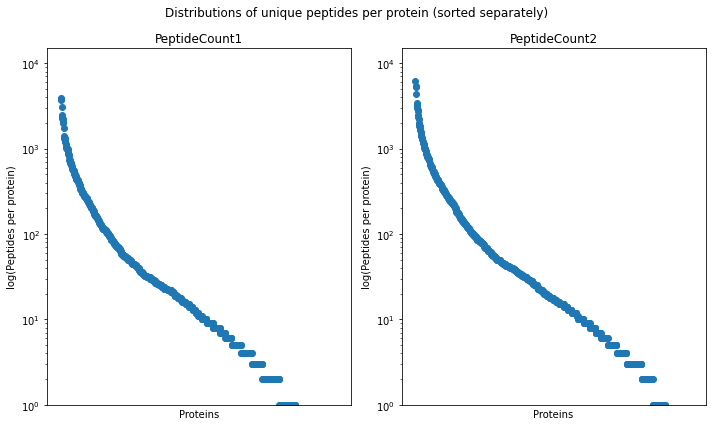

In [101]:
def plot_peptide_distribution(df):
    plt.clf()
    fig, axs = plt.subplots(1,2, figsize=(10,6))
    df = df.groupby('Protein', as_index=False).sum()
    

    
    for ax, PeptideCount in zip(axs.ravel(), ['PeptideCount1','PeptideCount2']):
        df.sort_values(PeptideCount, ascending=False, inplace=True)
        ax.scatter(x=range(len(df['Protein'])), y=df[PeptideCount].values)
        ax.tick_params(
            axis='x',         
            which='both',     
            bottom=False,      
            top=False,        
            labelbottom=False) 
        ax.set_yscale('log')
        ax.set_ylim([1, 1.5*10**4])
        ax.set_ylabel('log(Peptides per protein)')
        ax.set_xlabel('Proteins')
        ax.set_title(PeptideCount)
    plt.suptitle('Distributions of unique peptides per protein (sorted separately)')
    savefig('ProteinDistribution')
plot_peptide_distribution(df)

(1, 10000)

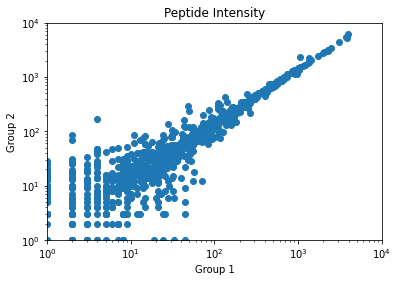

In [40]:
plt.clf()
df_protein_grouped = df.groupby('Protein').sum()
plt.scatter(x=df_protein_grouped['PeptideCount1'],y=df_protein_grouped['PeptideCount2'])
plt.title('Peptide Intensity')
plt.xlabel('Group 1')
plt.ylabel('Group 2')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1,10**4])
plt.xlim([1, 10**4])

### Differential expression
Peptide Level:

In [21]:
def get_p_value(row, GroupOneCols, GroupTwoCols):
    groupOneValues = row[GroupOneCols].values
    groupTwoValues = row[GroupTwoCols].values
    statistic, pvalue = stats.ttest_ind(groupOneValues, groupTwoValues)
    return pvalue

def get_log_fold_change(row, GroupOneCols, GroupTwoCols):
    groupOneValues = row[GroupOneCols].values
    groupTwoValues = row[GroupTwoCols].values
    log_fold_change = np.log2(np.mean(groupOneValues)) - np.log2(np.mean(groupTwoValues))
    return log_fold_change

df['pvalue'] = df.apply(lambda x: get_p_value(x, GroupOneCols, GroupTwoCols), axis=1)
df['log_fold']=df.apply(lambda x: get_log_fold_change(x, GroupOneCols, GroupTwoCols), axis=1)
df


,PeptideSequence,Charge,Decoy,Protein,RetentionTime,PeptideQValue,ProteinQValue,TM_M2012_010,TM_M2012_011,TM_M2012_012,...,TM_M2012_188,TM_M2012_189,TM_M2012_196,TM_M2012_197,TM_M2012_198,PeptideCount1,PeptideCount2,labels,pvalue,log_fold
1885,NPSSAGSWNSGSSGPGSTGNR,2,0,P02671,1770.050,0.000000,0.00000,76500800.0,6.027590e+08,210512000.0,...,58638600.0,103519000.0,26534700.0,30883000.0,31370200.0,30,42,P02671,0.688968,0.122427
2635,LTVLSQPK,2,0,P80748,2051.000,0.000000,0.00000,108445000.0,2.019230e+07,15145300.0,...,10843700.0,16062100.0,246851000.0,31863000.0,25429200.0,30,42,P80748,0.841966,0.076148
2639,AASGTTGTYQEWK,2,0,P04114,2051.590,0.000000,0.00000,4251980.0,6.607550e+06,10676400.0,...,5037230.0,8634130.0,13358300.0,10581600.0,9752750.0,30,42,P04114,0.074556,-0.427818
12404,EVVTSEDGSDC(UniMod:4)PEAMDLGTLSGIGTLDGFR,3,0,P02671,5310.340,0.000000,0.00000,239767000.0,1.901960e+09,652418000.0,...,215585000.0,381234000.0,10206800.0,122445000.0,113454000.0,30,42,P02671,0.307958,0.434715
2531,QTAC(UniMod:4)KPEIAYAYK,3,0,P01031,2006.840,0.000000,0.00000,4731040.0,6.521440e+06,5357530.0,...,2073940.0,3398480.0,4434620.0,2074700.0,1576140.0,30,42,P01031,0.454226,0.153404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4646,NVHGINFVSPVR,2,0,P53634,2709.160,0.000000,0.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Other,NaN,NaN
11199,LTFFNSTLNTSGLVPEGDALPIPGAHRPGVVTK,5,0,O75891,4666.005,0.009295,0.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Other,NaN,NaN
1713,QLEEEQQALQK,2,0,P07951,1692.150,0.000438,0.00222,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Other,NaN,NaN
4361,LFYSTFATDDRK,2,0,P30084,2623.420,0.001093,0.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Other,NaN,NaN


Text(0.5, 0, 'log2(Group 1 / Group 2)')

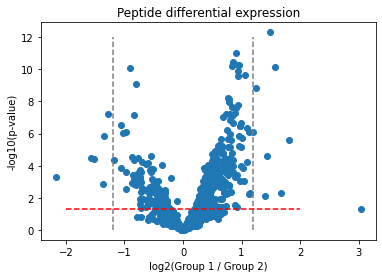

In [38]:
plt.scatter(x=df['log_fold'],y=[-np.log(val) for val in df['pvalue'].values])
plt.vlines(1.2, ymin=0, ymax=12, color='gray', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='gray', linestyle='dashed')
plt.hlines(1.31, xmin=-2, xmax=2, color='red', linestyle='dashed')
plt.title('Peptide differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

Protein level

/home/erikh/master-thesis/my-venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/erikh/master-thesis/my-venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'log2(Group 1 / Group 2)')

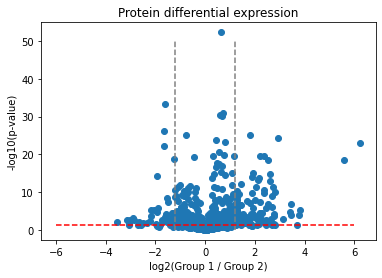

In [104]:
# Use LFQ for fold change later
pvalues = []
proteins = []
logfold_changes = []
for protein in df['Protein'].unique():
    protein_df = df[df['Protein'] == protein]
    vals_group_1 = protein_df[GroupOneCols].values.flatten()
    vals_group_2 = protein_df[GroupTwoCols].values.flatten()
    statistic, pval = stats.ttest_ind(vals_group_1[~np.isnan(vals_group_1)], vals_group_2[~np.isnan(vals_group_2)])
    logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
    
    pvalues.append(pval)
    proteins.append(protein)
    logfold_changes.append(logfold_change)



log_pval = [-np.log(x) for x in pvalues]
dep = pd.DataFrame({'protein':proteins, 'pval': log_pval, 'FC':logfold_changes})

plt.scatter(x=logfold_changes,y=log_pval)

plt.vlines(1.2, ymin=0, ymax=50, color='gray', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=50,color='gray', linestyle='dashed')
plt.hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
plt.title('Protein differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

In [105]:
dep = dep[dep['pval'] >1.3]
dep = dep[(dep['FC'] < -1.2) | (dep['FC'] > 1.2)]
dep

,protein,pval,FC
91,P59665,4.799446,-1.957532
115,P05362,33.263801,-1.630875
138,P01621,2.507833,1.421918
156,P01605,2.427054,1.713800
170,P01833,18.789981,-1.256498
...,...,...,...
912,P22234,1.345600,1.772979
917,Q96CN7,1.300812,1.430712
918,Q06278,4.007961,1.944154
923,Q8IZ83,1.735241,1.599218
